In [2]:
pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

# 🔹 Cargar los datos
df_btc = pd.read_csv("Database/btc_final.csv")

# 🔹 Convertir fechas a datetime
df_btc['Date'] = pd.to_datetime(df_btc['Date'])

# 🔹 Imputación de valores faltantes
tech_indicators = ['BTC_EMA_20', 'BTC_RSI', 'BTC_MACD']  # Eliminamos BTC_SMA_50

# Obtener los primeros dos meses de datos
start_date = df_btc['Date'].min()
end_date = start_date + pd.DateOffset(months=2)
df_initial = df_btc[(df_btc['Date'] >= start_date) & (df_btc['Date'] < end_date)]

# Rellenar indicadores técnicos con el promedio de los primeros dos meses
for col in tech_indicators:
    mean_value = df_initial[col].mean()
    df_btc.loc[:, col] = df_btc[col].fillna(mean_value)

# Rellenar Fear_Greed_Index con el promedio entre el valor anterior y el siguiente
df_btc.loc[:, 'Fear_Greed_Index'] = df_btc['Fear_Greed_Index'].interpolate(method='linear')

# 🔹 Eliminar variables redundantes
#df_btc.drop(columns=['BTC_SMA_50', 'BTC_Price_CryptoCompare', 'Open', 'High', 'Low'], inplace=True, errors='ignore')

# 🔹 Eliminar variables redundantes
df_btc.drop(columns=['BTC_SMA_50', 'Volume','BTC_Price_CryptoCompare', 'Open', 'High', 'Low', 'BTC_Trends'], inplace=True, errors='ignore') # 'BTC_Sentiment'

# 🔹 Normalizar los datos
scaler = MinMaxScaler()
df_scaled = df_btc.copy()
df_scaled[df_btc.columns.difference(['Date'])] = scaler.fit_transform(df_btc[df_btc.columns.difference(['Date'])])

# 🔹 Mover la columna "Close" al final
df_scaled = df_scaled[[col for col in df_scaled.columns if col != "Close"] + ["Close"]]
# 🔹 Eliminar la columna de fechas antes de guardar
df_scaled = df_scaled.drop(columns=['Date'], errors='ignore')

# 🔹 Guardar datasets preprocesados
np.save("Dataset/df_scaled_btc.npy", df_scaled.values)
print("✅ Datos preprocesados guardados en Dataset/")

2025-03-16 13:24:38.615947: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


✅ Datos preprocesados guardados en Dataset/


#### Crear secuencias de tiempo (Seleccion aleatorea)

In [5]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

# 🔹 Cargar los datos normalizados
df_scaled = np.load("Dataset/df_scaled_btc.npy", allow_pickle=True)

# 🔹 Crear secuencias para LSTM
sequence_length = 60  # 60 días de ventana
def create_sequences(data, target_index, sequence_length):
    sequences, targets = [], []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i : i + sequence_length, :-1])  # Features
        targets.append(data[i + sequence_length, target_index])  # Target
    return np.array(sequences), np.array(targets)

# Definir la posición de la variable objetivo (última columna en df_scaled)
target_index = -1  # Última columna (precio futuro)

X, Y = create_sequences(df_scaled, target_index, sequence_length)

# 🔹 Dividir en Train/Test
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = Y[:train_size], Y[train_size:]

# 🔹 Guardar datasets para evitar desorden
np.save("Dataset/X_train_btc.npy", X_train)
np.save("Dataset/X_test_btc.npy", X_test)
np.save("Dataset/y_train_btc.npy", y_train)
np.save("Dataset/y_test_btc.npy", y_test)
print("✅ Datasets para LSTM guardados en Dataset/")

✅ Datasets para LSTM guardados en Dataset/


#### definir y entrenar el modelo Hybrid CNN + LSTM

/opt/conda/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - loss: 0.0482 - val_loss: 0.0031
Epoch 2/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 10s 120ms/step - loss: 0.0033 - val_loss: 0.0088
Epoch 3/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 114ms/step - loss: 0.0017 - val_loss: 0.0119
Epoch 4/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 10s 117ms/step - loss: 0.0011 - val_loss: 0.0102
Epoch 5/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 10s 122ms/step - loss: 0.0012 - val_loss: 0.0120
Epoch 6/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step - loss: 9.7027e-04 - val_loss: 0.0137
Epoch 7/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 10s 109ms/step - loss: 7.7992e-04 - val_loss: 0.0167
Epoch 8/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step - loss: 8.8443e-04 - val_loss: 0.0161
Epoch 9/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 10s 115ms/step - loss: 9.0024e-04 - val_loss: 0.0183
Epoch 10/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 119ms/step - loss: 8.0777e-04 - val_loss: 0.0232
Epoch 11/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 10s 113ms/step - loss: 7.8948e-04 - val_loss: 0.0246
Epoch 12/1

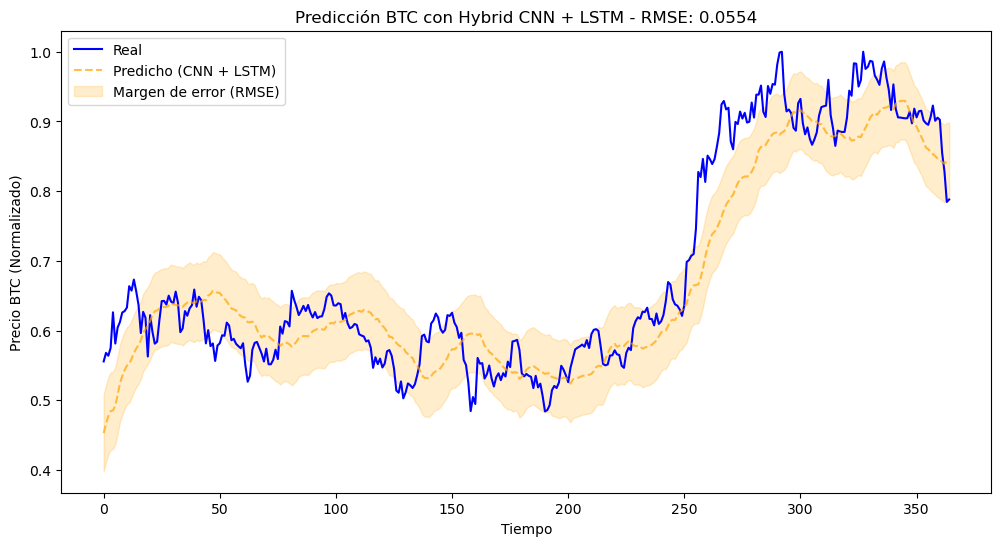

In [4]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv1D, LSTM, Dense, Dropout, Flatten
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import numpy as np
import matplotlib.pyplot as plt

# Cargar datasets preprocesados
X_train = np.load("Dataset/X_train_btc.npy")
X_test = np.load("Dataset/X_test_btc.npy")
y_train = np.load("Dataset/y_train_btc.npy")
y_test = np.load("Dataset/y_test_btc.npy")

# 🔹 Construcción del modelo Hybrid CNN + LSTM
model_cnn_lstm = Sequential([
    # 🔹 Capa CNN para extraer patrones temporales
    Conv1D(filters=64, kernel_size=3, activation="relu", padding="same", input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),

    # 🔹 LSTM para capturar dependencias a largo plazo
    LSTM(128, return_sequences=False, activation='tanh'),
    Dropout(0.2),

    # 🔹 Capas densas finales
    Dense(64, activation="relu"),
    Dense(32, activation="relu"),
    Dense(1, activation="linear")  # Predicción final
])

# 🔹 Compilar modelo
model_cnn_lstm.compile(optimizer=Adam(learning_rate=0.0005), loss="mse")

# 🔹 Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# 🔹 Entrenar el modelo
history_cnn_lstm = model_cnn_lstm.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping]
)

# 🔹 Evaluación del modelo
loss_cnn_lstm = model_cnn_lstm.evaluate(X_test, y_test)
rmse_cnn_lstm = np.sqrt(loss_cnn_lstm)
print(f"📉 RMSE del modelo Hybrid CNN + LSTM: {rmse_cnn_lstm:.4f}")

# 🔹 Convertir RMSE normalizado a dólares usando MAD
btc_mad = np.median(np.abs(df_btc["Close"] - df_btc["Close"].median()))
rmse_dollars_cnn_lstm = rmse_cnn_lstm * btc_mad
print(f"💰 RMSE en dólares con Hybrid CNN + LSTM: ${rmse_dollars_cnn_lstm:.2f}")

# 🔹 Predicciones
y_pred_cnn_lstm = model_cnn_lstm.predict(X_test)

# 🔹 Gráfica de predicción vs. valores reales
plt.figure(figsize=(12, 6))
plt.plot(y_test, label="Real", color='blue')
plt.plot(y_pred_cnn_lstm, label="Predicho (CNN + LSTM)", linestyle="dashed", color='orange', alpha=0.7)
plt.fill_between(range(len(y_test)), y_pred_cnn_lstm.flatten() - rmse_cnn_lstm, y_pred_cnn_lstm.flatten() + rmse_cnn_lstm, color='orange', alpha=0.2, label="Margen de error (RMSE)")
plt.xlabel("Tiempo")
plt.ylabel("Precio BTC (Normalizado)")
plt.legend()
plt.title(f"Predicción BTC con Hybrid CNN + LSTM - RMSE: {rmse_cnn_lstm:.4f}")
plt.show()

In [8]:
# 🔹 Guardar el modelo entrenado
model.save("model_cnn_lstm.keras")
print("✅ Modelo LSTM guardado en model_cnn_lstm.keras")

✅ Modelo LSTM guardado en model_cnn_lstm.keras


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step 


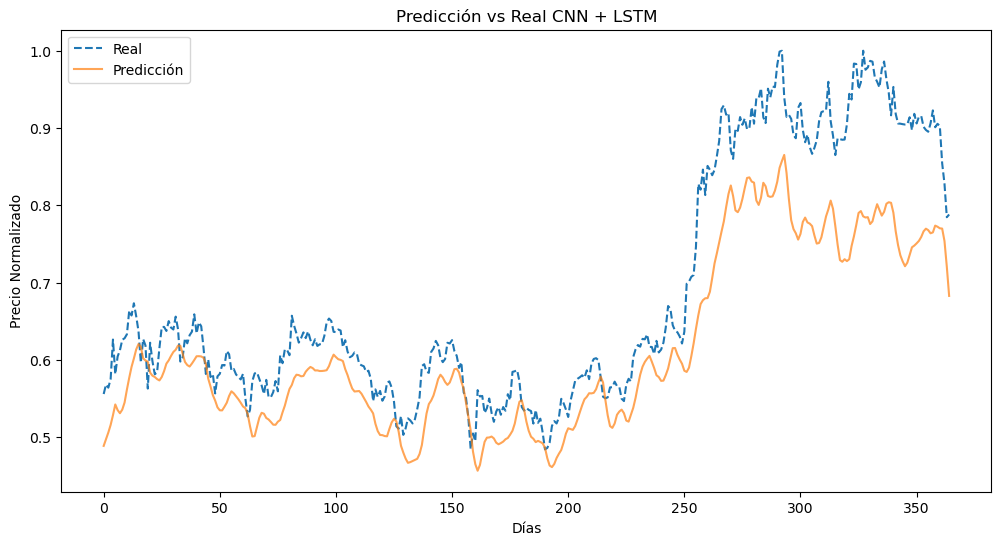

💰 RMSE en dólares: $491.55
📉 Error Cuadrático Medio (MSE): 0.007767363060628781
📉 Raíz del Error Cuadrático Medio (RMSE): 0.08813264469326211


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import load_model

# 🔹 Cargar los datasets para evaluar el modelo
X_test = np.load("Dataset/X_test_btc.npy", allow_pickle=True)
y_test = np.load("Dataset/y_test_btc.npy", allow_pickle=True)

# 🔹 Cargar el modelo entrenado
model = load_model("model_cnn_lstm.keras")

# 🔹 Hacer predicciones
y_pred = model.predict(X_test)

# 🔹 Desescalar los valores predichos y reales
y_test = y_test.reshape(-1, 1)
y_pred = y_pred.reshape(-1, 1)

# 🔹 Visualizar las predicciones
plt.figure(figsize=(12, 6))
plt.plot(y_test, label="Real", linestyle='dashed')
plt.plot(y_pred, label="Predicción", alpha=0.7)
plt.legend()
plt.title("Predicción vs Real CNN + LSTM")
plt.xlabel("Días")
plt.ylabel("Precio Normalizado")
plt.show()

# 🔹 Evaluar el modelo
mse = np.mean((y_pred - y_test) ** 2)
rmse = np.sqrt(mse)

# 🔹 Obtener la desviación real del precio de BTC en el dataset
btc_price_std = np.std(y_pred) * 50000  # Ajustamos escala para convertirlo a USD
rmse_dollars = rmse * btc_price_std
print(f"💰 RMSE en dólares: ${rmse_dollars:.2f}")
print(f"📉 Error Cuadrático Medio (MSE): {mse}")
print(f"📉 Raíz del Error Cuadrático Medio (RMSE): {rmse}")